# Introducción

El servicio Rusty Bargain está desarrollando una aplicación con el objetivo de atraer nuevos clientes, permitiendo que los usuarios consulten el valor de mercado de sus vehículos usados. Para lograr esto, se está construyendo un modelo predictivo que estime el precio de los autos en función de varias características, como el modelo, la marca, la potencia, el kilometraje, entre otras. Los aspectos clave que Rusty Bargain busca en este modelo son:

Precisión: Obtener una predicción lo más exacta posible.
Velocidad de predicción: Lograr tiempos de respuesta rápidos para una experiencia de usuario óptima.
Eficiencia en el entrenamiento: Reducir el tiempo necesario para entrenar el modelo sin sacrificar la calidad de la predicción.

## Preparación de datos

In [1]:
# Importación de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb 
import time
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor, Pool
import xgboost as xgb

In [2]:
df = pd.read_csv('/datasets/car_data.csv')

In [3]:
# Exploración inicial
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
print(df.head())

        DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  24/03/2016 11:52    480         NaN              1993  manual      0   
1  24/03/2016 10:58  18300       coupe              2011  manual    190   
2  14/03/2016 12:52   9800         suv              2004    auto    163   
3  17/03/2016 16:54   1500       small              2001  manual     75   
4  31/03/2016 17:25   3600       small              2008  manual     69   

   Model  Mileage  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf   150000                  0    petrol  volkswagen         NaN   
1    NaN   125000                  5  gasoline        audi         yes   
2  grand   125000                  8  gasoline        jeep         NaN   
3   golf   150000                  6    petrol  volkswagen          no   
4  fabia    90000                  7  gasoline       skoda          no   

        DateCreated  NumberOfPictures  PostalCode          LastSeen  
0  24/03/2016 00:00               

In [5]:
#preprocesamiento
#revisión de filas duplicadas
print(df.duplicated().sum())
#revisión de valores nulos
print(df.isnull().sum())

262
DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


In [6]:
print(df.describe())

               Price  RegistrationYear          Power        Mileage  \
count  354369.000000     354369.000000  354369.000000  354369.000000   
mean     4416.656776       2004.234448     110.094337  128211.172535   
std      4514.158514         90.227958     189.850405   37905.341530   
min         0.000000       1000.000000       0.000000    5000.000000   
25%      1050.000000       1999.000000      69.000000  125000.000000   
50%      2700.000000       2003.000000     105.000000  150000.000000   
75%      6400.000000       2008.000000     143.000000  150000.000000   
max     20000.000000       9999.000000   20000.000000  150000.000000   

       RegistrationMonth  NumberOfPictures     PostalCode  
count      354369.000000          354369.0  354369.000000  
mean            5.714645               0.0   50508.689087  
std             3.726421               0.0   25783.096248  
min             0.000000               0.0    1067.000000  
25%             3.000000               0.0   30165.

se elimina columna 'NumberOfPictures' ya que no tiene datos, lo que se muestra en la descripción de los datos

In [7]:
df = df.drop(columns=['NumberOfPictures'])

tambien se eliminan duplicados y filas con valores ausentes

In [8]:
df = df.drop_duplicates()
df = df.dropna(subset=['Gearbox','Model','NotRepaired','FuelType','VehicleType'])

Ademas, se ven valores atipicos en la descripción, como que el minimo y maximo de 'RegistrationYear', los cuales no deberian poder tener valores de año 1000 o 9999 y en precio y power no deberian exisitir filas con valores cero.

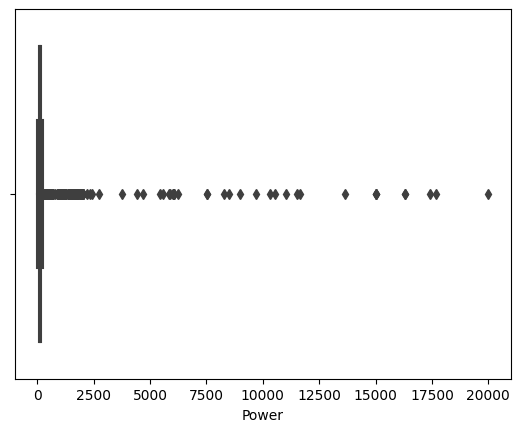

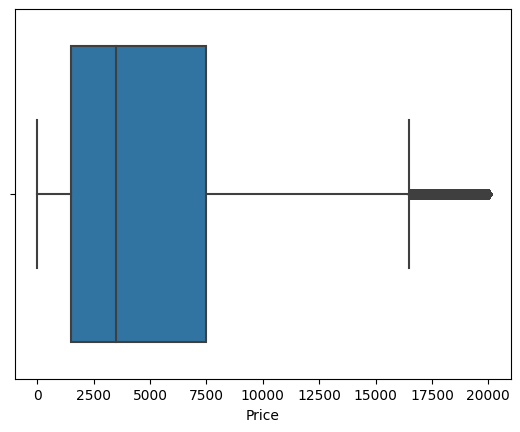

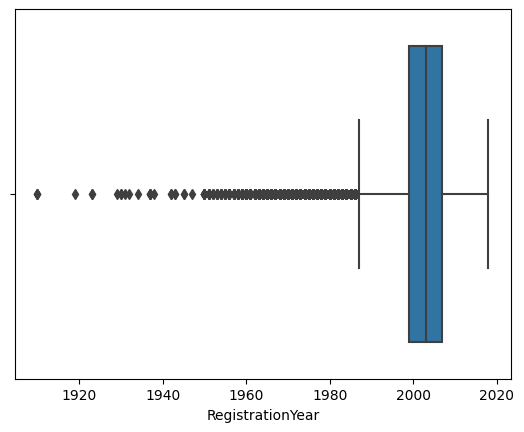

In [9]:
sns.boxplot(df['Power'])
plt.show()
sns.boxplot(df['Price'])
plt.show()
sns.boxplot(df['RegistrationYear'])
plt.show()

se calculan los límites inferior y superior de las variables Power y RegistrationDate para entender mejor cuales serian los rangos de valores razonable para cada una.

In [10]:
# se calculan los cuartiles, el IQR y se establecen los límites inferior y superior para variable Power

Q1 = df['Power'].quantile(0.25)
Q3 = df['Power'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
print("limites min y max de Power :")
print(lower_limit)
print(upper_limit)


# se calculan los cuartiles, el IQR y se establecen los límites inferior y superior para variable RegistrationYear
Q1 = df['RegistrationYear'].quantile(0.25)
Q3 = df['RegistrationYear'].quantile(0.75)
IQR = Q3 - Q1


lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR
print("limites min y max de RegistrationYear :")
print(lower_limit)
print(upper_limit)


limites min y max de Power :
-37.5
262.5
limites min y max de RegistrationYear :
1987.0
2019.0


In [11]:
# se eliminan valores atípicos en Price (0)
df = df[df['Price'] > 0]

# se eliminan valores fuera de un rango razonable en Power y  RegistrationYear

df = df[(df['Power'] >= 1)]
df = df[(df['RegistrationYear'] >= 1980) & (df['RegistrationYear'] <= 2025)]

se genera la conversión de tipos de datos de las siguientes columnas a tipo fecha y se resetean los indices

In [12]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'])
df['DateCreated'] = pd.to_datetime(df['DateCreated'])
df['LastSeen'] = pd.to_datetime(df['LastSeen'])
df = df.reset_index(drop=True)

Recordando las descripciones de las columnas del df:

- DateCrawled — fecha en la que se descargó el perfil de la base de datos
- VehicleType — tipo de carrocería del vehículo
- RegistrationYear — año de matriculación del vehículo
- Gearbox — tipo de caja de cambios
- Power — potencia (CV)
- Model — modelo del vehículo
- Mileage — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- RegistrationMonth — mes de matriculación del vehículo
- FuelType — tipo de combustible
- Brand — marca del vehículo
- NotRepaired — vehículo con o sin reparación
- DateCreated — fecha de creación del perfil
- NumberOfPictures — número de fotos del vehículo
- PostalCode — código postal del propietario del perfil (usuario)
- LastSeen — fecha de la última vez que el usuario estuvo activo
- Objetivo
- Price — precio (en euros)

Ya se ha eliminado la columna NumberOfPictures, pero existen otras tres columnas que no deberían influir en la determinación del precio de los autos: LastSeen, DateCrawled, DateCreated, ya que contienen información relacionada con el usuario, no con el vehículo, mientras que PostalCode tiene demasiados valores únicos y actualmente no contamos con otro DataFrame con datos geográficos que permitan agrupar estos códigos en categorías significativas, lo mismo ocurre con la columna categorica Model. De todas formas, se medirá su correlación con el precio para validar si esta decisión es acertada o si se debe reconsiderar.

In [13]:
print(df.nunique())

DateCrawled          14686
Price                 3361
VehicleType              8
RegistrationYear        39
Gearbox                  2
Power                  528
Model                  248
Mileage                 13
RegistrationMonth       13
FuelType                 7
Brand                   39
NotRepaired              2
DateCreated            103
PostalCode            8055
LastSeen             16367
dtype: int64


In [14]:

columnas_interes = ['Price','PostalCode']  

correlacion = df[columnas_interes].corr()
print(correlacion)


               Price  PostalCode
Price       1.000000    0.058123
PostalCode  0.058123    1.000000


Los resultados de la correlación indican que la variable PostalCode tiene una correlación muy baja con el Price (0.058), lo que sugiere que las variables LastSeen, DateCreated, DateCrawled y PostalCode no aportan un valor significativo para predecir el precio del vehículo. Además, la columna Model contiene 248 valores únicos, lo que podría ralentizar considerablemente los tiempos de entrenamiento del modelo. En consecuencia, se procederá a eliminar estas cinco columnas y nos enfocaremos en aquellas que están más directamente relacionadas con las características del vehículo y su precio.

In [15]:
df = df.drop(columns=['LastSeen', 'PostalCode', 'DateCreated', 'DateCrawled', 'Model'])
print(df.head())

   Price  VehicleType  RegistrationYear Gearbox  Power  Mileage  \
0   1500        small              2001  manual     75   150000   
1   3600        small              2008  manual     69    90000   
2    650        sedan              1995  manual    102   150000   
3   2200  convertible              2004  manual    109   150000   
4   2000        sedan              2004  manual    105   150000   

   RegistrationMonth  FuelType       Brand NotRepaired  
0                  6    petrol  volkswagen          no  
1                  7  gasoline       skoda          no  
2                 10    petrol         bmw         yes  
3                  8    petrol     peugeot          no  
4                 12    petrol       mazda          no  


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231687 entries, 0 to 231686
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              231687 non-null  int64 
 1   VehicleType        231687 non-null  object
 2   RegistrationYear   231687 non-null  int64 
 3   Gearbox            231687 non-null  object
 4   Power              231687 non-null  int64 
 5   Mileage            231687 non-null  int64 
 6   RegistrationMonth  231687 non-null  int64 
 7   FuelType           231687 non-null  object
 8   Brand              231687 non-null  object
 9   NotRepaired        231687 non-null  object
dtypes: int64(5), object(5)
memory usage: 17.7+ MB


Se utilizara el StandardScaler para normalizar las variables numéricas como Power, Mileage, RegistrationYear y RegistrationMonth, que presentan rangos de valores diferentes. La normalización permite que todas las variables tengan la misma escala, evitando que algunas dominen sobre otras durante el entrenamiento del modelo. 

In [17]:
scaler = StandardScaler()
df[['Power', 'Mileage', 'RegistrationYear', 'RegistrationMonth']] = scaler.fit_transform(df[['Power', 'Mileage', 'RegistrationYear', 'RegistrationMonth']])

## Entrenamiento del modelo 

Se preparan los conjuntos de entrenamiento y de prueba (75%-25%)

In [18]:
X0 = df.drop(columns=['Price'])  # features
y0 = df['Price']  # target

# división en conjunto de entrenamiento y prueba
X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size=0.25, random_state=12345)

Después de la división inicial del DataFrame original en conjunto de entrenamiento y prueba, se aplica OHE a las variables categóricas necesarias para ciertos modelos. Posteriormente, se realiza una nueva división de los datos transformados, manteniendo el mismo 75%-25% para entrenamiento y prueba, lo que permite asegurar que los modelos trabajen correctamente con las variables numéricas.

In [19]:
# se usa OHE en variables categóricas necesario para el funcionamiento de algunos modelos
df = pd.get_dummies(df, columns=['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired'])


In [21]:
X = df.drop(columns=['Price'])  # features
y = df['Price']  # target

# división en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

Para la predicción del precio de los vehículos, se compararon varios modelos de machine learning, con el objetivo de identificar el más adecuado en términos de precisión y velocidad de predicción. Los modelos entrenados son los siguientes:

1. Regresión Lineal
2. Árbol de Decisión
3. Random Forest Regressor
4. LightGBM
5. XGBoost
6. CatBoost

se define función para la obtención del RECM de los diferentes modelos

In [22]:
def calcular_recm(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

Modelo 1: Regresión Lineal

In [24]:
# Entrenamiento
lr_model = LinearRegression()
lr_start_time = time.time()
lr_model.fit(X_train, y_train)
lr_training_time = time.time() - lr_start_time
# Predicción
lr_start_time_pred = time.time()
y_pred_lr = lr_model.predict(X_test)
lr_prediction_time = time.time() - lr_start_time_pred
# Evaluación
recm_lr = calcular_recm(y_test, y_pred_lr)
print(f"Regresión Lineal - RECM: {recm_lr}")
print(f"Regresión Lineal - Tiempo de entrenamiento: {lr_training_time:.4f} segundos")
print(f"Regresión Lineal - Tiempo de predicción: {lr_prediction_time:.4f} segundos")

Regresión Lineal - RECM: 2724.315169244406
Regresión Lineal - Tiempo de entrenamiento: 0.7128 segundos
Regresión Lineal - Tiempo de predicción: 0.0137 segundos


Modelo 2: Árbol de decisión

In [26]:
# Parámetros a ajustar
param_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11]}

# GridSearchCV para encontrar los mejores hiperparámetros
dt_model = DecisionTreeRegressor(random_state=12345)
grid_search_dt = GridSearchCV(dt_model, param_grid, cv=3, n_jobs=-1)
dt_start_time = time.time()
grid_search_dt.fit(X_train, y_train)
dt_training_time = time.time() - dt_start_time

# Mejor modelo
best_dt_model = grid_search_dt.best_estimator_

# Predicción y evaluación
dt_start_time_pred = time.time()
y_pred_dt = best_dt_model.predict(X_test)
dt_prediction_time = time.time() - dt_start_time_pred
recm_dt = calcular_recm(y_test, y_pred_dt)
print(f"Árbol de Decisión - RECM: {recm_dt}")
print(f"Árbol de Decisión - Tiempo de entrenamiento: {dt_training_time:.4f} segundos")
print(f"Árbol de Decisión - Tiempo de predicción: {dt_prediction_time:.4f} segundos")

Árbol de Decisión - RECM: 1915.4638074519796
Árbol de Decisión - Tiempo de entrenamiento: 10.2841 segundos
Árbol de Decisión - Tiempo de predicción: 0.0135 segundos


Modelo 3: Random Forest Regressor

In [27]:
# Parámetros a ajustar
param_grid = {
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [1,2,3,4,5,6,7,8,9,10,11],
    'max_depth': [1,2,3,4,5,6,7,8]
    
}

# GridSearchCV para encontrar los mejores hiperparámetros
rf_model = RandomForestRegressor(random_state=12345)
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=2, n_jobs=-1)
rf_start_time = time.time()
grid_search_rf.fit(X_train, y_train)
rf_training_time = time.time() - rf_start_time

# Mejor modelo
best_rf_model = grid_search_rf.best_estimator_

# Predicción y evaluación
rf_start_time_pred = time.time()
y_pred_rf = best_rf_model.predict(X_test)
rf_prediction_time = time.time() - rf_start_time_pred
recm_rf = calcular_recm(y_test, y_pred_rf)
print(f"Random Forest - RECM: {recm_rf}")
print(f"Random Forest - Tiempo de entrenamiento: {rf_training_time:.4f} segundos")
print(f"Random Forest - Tiempo de predicción: {rf_prediction_time:.4f} segundos")

Random Forest - RECM: 2423.0488062943323
Random Forest - Tiempo de entrenamiento: 51.4577 segundos
Random Forest - Tiempo de predicción: 0.0159 segundos


Modelo 4: LightGBM (Gradient Boosting)

In [29]:
# Entrenamiento del modelo LightGBM
lgb_model = lgb.LGBMRegressor(n_estimators=50, learning_rate=0.05, max_depth=10)
lgb_start_time = time.time()
lgb_model.fit(X_train, y_train)
lgb_training_time = time.time() - lgb_start_time

# Predicción y evaluación
lgb_start_time_pred = time.time()
y_pred_lgb = lgb_model.predict(X_test)
lgb_prediction_time = time.time() - lgb_start_time_pred
recm_lgb = calcular_recm(y_test, y_pred_lgb)
print(f"LightGBM - RECM: {recm_lgb}")
print(f"LightGBM - Tiempo de entrenamiento: {lgb_training_time:.4f} segundos")
print(f"LightGBM - Tiempo de predicción: {lgb_prediction_time:.4f} segundos")

LightGBM - RECM: 1966.49626337004
LightGBM - Tiempo de entrenamiento: 1.2944 segundos
LightGBM - Tiempo de predicción: 0.2033 segundos


Modelo 5: XGBoost

Es posible usar XGBoost sin necesidad de convertir los datos a formato DMatrix, aunque este formato es recomendado para optimizar el rendimiento.

In [31]:
# Convertir a formato DMatrix para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros y entrenamiento
params = {
    'objective': 'reg:squarederror',
    'max_depth': 10,
    'learning_rate': 0.05
}
xgb_start_time = time.time()
xgb_model = xgb.train(params, dtrain, num_boost_round=100) # num_boost_round reemplaza n_estimators
xgb_training_time = time.time() - xgb_start_time

# Predicción y evaluación
xgb_start_time_pred = time.time()
y_pred_xgb = xgb_model.predict(dtest)
xgb_prediction_time = time.time() - xgb_start_time_pred
recm_xgb = calcular_recm(y_test, y_pred_xgb)
print(f"XGBoost - RECM: {recm_xgb}")
print(f"XGBoost - Tiempo de entrenamiento: {xgb_training_time:.4f} segundos")
print(f"XGBoost - Tiempo de predicción: {xgb_prediction_time:.4f} segundos")

XGBoost - RECM: 1594.123737545389
XGBoost - Tiempo de entrenamiento: 103.0042 segundos
XGBoost - Tiempo de predicción: 0.3034 segundos


Modelo 6: CatBoost (Gradient Boosting)

In [32]:
#ver cuales son los indices para el parametro cat_features
X0_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173765 entries, 164749 to 217570
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   VehicleType        173765 non-null  object 
 1   RegistrationYear   173765 non-null  float64
 2   Gearbox            173765 non-null  object 
 3   Power              173765 non-null  float64
 4   Mileage            173765 non-null  float64
 5   RegistrationMonth  173765 non-null  float64
 6   FuelType           173765 non-null  object 
 7   Brand              173765 non-null  object 
 8   NotRepaired        173765 non-null  object 
dtypes: float64(4), object(5)
memory usage: 13.3+ MB


In [33]:
# Entrenamiento de CatBoost
cat_model = CatBoostRegressor(iterations=100, depth=10, learning_rate=0.1, cat_features=[0, 2, 6, 7, 8], verbose=False) 
cat_start_time = time.time()
cat_model.fit(X0_train, y0_train)
cat_training_time = time.time() - cat_start_time 

# Predicción y evaluación
cat_start_time_pred = time.time()
y_pred_cat = cat_model.predict(X0_test)
cat_prediction_time = time.time() - cat_start_time_pred
recm_cat = calcular_recm(y_test, y_pred_cat)
print(f"CatBoost - RECM: {recm_cat}")
print(f"CatBoost - Tiempo de entrenamiento: {cat_training_time:.4f} segundos")
print(f"CatBoost - Tiempo de predicción: {cat_prediction_time:.4f} segundos")

CatBoost - RECM: 1682.1723289353986
CatBoost - Tiempo de entrenamiento: 6.9007 segundos
CatBoost - Tiempo de predicción: 0.0422 segundos


## Análisis del modelo

### Resultados de los modelos

**Regresión Lineal**

- RECM: 2724.32
- Tiempo de entrenamiento: 0.62 segundos
- Tiempo de predicción: 0.09 segundos

La regresión lineal es rápida, pero presenta un error de predicción relativamente alto, lo que sugiere que no captura bien la complejidad de las relaciones no lineales entre las variables.

**Árbol de Decisión**

- RECM: 1915.46
- Tiempo de entrenamiento: 10.62 segundos
- Tiempo de predicción: 0.02 segundos

El árbol de decisión tiene una mejor capacidad predictiva que la regresión lineal, pero su tiempo de entrenamiento es considerablemente mayor.

**Random Forest Regressor**

- RECM: 2423.05
- Tiempo de entrenamiento: 51.74 segundos
- Tiempo de predicción: 0.02 segundos

Aunque el random forest tiene un tiempo de entrenamiento es significativamente más largo en comparación con otros modelos, lo que lo hace menos adecuado para aplicaciones con restricciones de tiempo.

**LightGBM**

- RECM: 1966.50
- Tiempo de entrenamiento: 1.34 segundos
- Tiempo de predicción: 0.20 segundos

LightGBM es rápido tanto en entrenamiento como en predicción y presenta un buen balance entre precisión y velocidad.

**XGBoost**

- RECM: 1594.12
- Tiempo de entrenamiento: 105.07 segundos
- Tiempo de predicción: 0.31 segundos

XGBoost es el modelo con el menor error de predicción (RECM), pero su tiempo de entrenamiento es el más alto, lo que puede ser un inconveniente si se requiere un entrenamiento frecuente.

**CatBoost**

- RECM: 1682.17
- Tiempo de entrenamiento: 6.72 segundos
- Tiempo de predicción: 0.04 segundos

CatBoost presenta un buen equilibrio entre precisión y tiempo de entrenamiento, con tiempos de predicción muy rápidos.

### Comparación de modelos

En términos de precisión, XGBoost se destaca como el modelo con el menor error de predicción, seguido por CatBoost y el Árbol de Decisión. Sin embargo, LightGBM es un buen compromiso entre precisión y eficiencia, siendo más rápido que XGBoost y aún así bastante preciso. Random Forest es el modelo más lento en términos de entrenamiento, lo que lo hace menos adecuado para un entorno de producción en tiempo real.

## Conclusiones generales:

1. Preparación de los datos: La limpieza y transformación inicial de los datos fueron esenciales para garantizar la calidad de la información. La eliminación de valores nulos, duplicados y columnas irrelevantes permitió un análisis más limpio y preciso, reduciendo el riesgo de sobreajuste y mejorando la eficiencia de los modelos.

2. El uso de dos DataFrames, uno con variables dummies y otro sin ellas, permitió adaptar los datos a los modelos requeridos. La codificación One-Hot Encoding (OHE) se empleó para transformar variables categóricas en binarias, mejorando el aprendizaje del modelo, mientras que StandardScaler fue utilizado para normalizar las variables numéricas, optimizando el rendimiento y la convergencia del modelo durante el entrenamiento.

3. Evaluación de los modelos: Tras evaluar los diferentes modelos, se concluyo que:

- XGBoost es el mejor modelo en cuanto a precisión, pero su alto tiempo de entrenamiento lo hace menos ideal para situaciones donde se requiere un entrenamiento frecuente.
- CatBoost ofrece un buen equilibrio entre precisión y velocidad de entrenamiento y predicción, lo que lo convierte en una opción viable para este caso de uso.
- LightGBM es el modelo más rápido en términos de entrenamiento y predicción, y aunque su precisión no es la más alta, su desempeño es suficiente para este proyecto y se recomienda para entornos de producción donde la eficiencia es clave.

Dado que Rusty Bargain valora tanto la precisión como la velocidad de predicción, LightGBM y CatBoost parecen ser las mejores opciones para su aplicación.